# Istanbul Rental Housing Prices and Venues - Data Analysis

## 1. Introduction

### 1.1 Description and Disscusion of the Background

Istanbul is one of the largest metropolises in the world where over 15 million people live and it has a population density of 2,902 people per square kilometer. The city is divided into 39 districts in total, 14 of them belong to the Asian side and the other 25 belong to the European side. However, the fact that the districts are squeezed into an area of approximately 72 square kilometers causes the city to have a very intertwined and mixed structure.

The city has been always a destination for students around the world to start or continue their studies, where it has 52 universities out of 175 universities in all Turkey. When we think of the city students, they probably want to choose the regions where rental housing values are low. At the same time, they may want to choose the district according to the social places density.

When we consider the previous problem, we can create a map and information chart where the rental housing index is placed on Istanbul and each district is clustered according to the venues density.

### 1.2 Data Description

To consider the problem we can list the datas as below:

1) I found a list of districts of Istanbul, which i cleaned and convert to a dataframe. Then I used the `geopy` library to get the districts coordinates where I used it to create choropleth map of Rental Housing Price Index of Istanbul.

2) There are not too many public data related to demographic and social parameters for the city of Istanbul.Therefor you must set-up your own data tables in most cases. In this case, I collected latest Rental Housing Price Averages for each district of Istanbul from housing retail web page.

3) I used the .json file of the Second-level Administrative Divisions of the Turkey from Spatial Data Repository of NYU, which I borrowed from Sercan Yıldız Github repository, to create a choropleth map of Average Rental Housing Index of Istanbul.

4) I used Forsquare API to get the most common venues of given district of Istanbul.

## 2. Methodology

### 2.1 Importing Libraries

First let's download the dependencies that we will need.

In [2]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import requests # library to handle requests
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import matplotlib.cm as cm
import matplotlib.colors as colors
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans # import k-means for clustering stage
import folium # map rendering library
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

### 2.2 Preparing the Districts Dataset

I found a list of districts of Istanbul on wikipedia "https://en.wikipedia.org/wiki/List_of_districts_of_Istanbul".

Then I extracted the related table and cleaned it as follows:

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_districts_of_Istanbul'
html = requests.get(url).content
df_list = pd.read_html(html) # Extract all tables from our wiki page (html) and puts them in a list of dataframes
istanbul_dis = df_list[-2] # For our web page, the relevant table is the third one from the bottom.
istanbul_dis.to_csv('istanbul_districts.csv') # Convert the relevant dataframe (table) to a csv file

# Insert a new column that include the address of each district 
istanbul_dis['City'] = 'Istanbul, Turkey'
istanbul_dis['address'] = istanbul_dis['District'].str.cat(istanbul_dis['City'],sep=", ")

# Using the geopy library to get the districts coordinates based on their addresses  
geolocator = Nominatim(user_agent="istanbul_explorer")
istanbul_dis["loc"] = istanbul_dis["address"].apply(geolocator.geocode)
istanbul_dis["point"] = istanbul_dis["loc"].apply(lambda loc: tuple(loc.point) if loc else None)
istanbul_dis[['Latitude', 'Longitude', 'alt']] = pd.DataFrame(istanbul_dis['point'].to_list(), index=istanbul_dis.index)

# Cleaning the dataframe 
istanbul_dis = istanbul_dis.drop(index=[39,40,41,42], columns=['loc', 'point', 'alt', 'address', 'City', 'Mensual household income TL(USD)',
                                                               'Annual household income TL(USD)', 'Area (km²)', 'Density (per km²)'])
istanbul_dis.head()

,District,Population (2019),Latitude,Longitude
0,Adalar,15238,40.876259,29.091027
1,Arnavutköy,282488,41.184182,28.740729
2,Ataşehir,425094,40.984749,29.106720
3,Avcılar,448882,40.980135,28.717547
4,Bağcılar,745125,41.033899,28.857898


### 2.3 Preparing the Rental Housing Prices Dataset

I collected latest Rental Housing Price Averages for each district of Istanbul from "https://www.endeksa.com" and I put them in a table respectively.

Then I created a csv file and converted it to a dataframe which looks like this:

In [43]:
istanbul_rental = pd.read_csv(body)
istanbul_rental.head()

,District,District Side,Avg-Rent (Lira),Avg-Rent (USD)
0,Adalar,Asian,1874,244
1,Arnavutkoy,European,857,111
2,Atasehir,Asian,1632,212
3,Avcilar,European,1364,177
4,Bagcilar,European,1337,174


### 2.4 Preparing the Master Dataset

After creating the Districts and Rental Housing Prices dataframes, I merged them into one main dataframe which I am going to use for later analysis.

In [5]:
istanbul_dis = istanbul_dis.drop(columns=['District'])
istanbul_main = istanbul_rental.join(istanbul_dis, how='inner')
istanbul_main.head()

,District,District Side,Avg-Rent (Lira),Avg-Rent (USD),Population (2019),Latitude,Longitude
0,Adalar,Asian,1874,244,15238,40.876259,29.091027
1,Arnavutkoy,European,857,111,282488,41.184182,28.740729
2,Atasehir,Asian,1632,212,425094,40.984749,29.106720
3,Avcilar,European,1364,177,448882,40.980135,28.717547
4,Bagcilar,European,1337,174,745125,41.033899,28.857898


### 2.5 Visualizing the Districts Geographically

I used python `folium` library to visualize geographic details of Istanbul and its districts, and I created a map of Istanbul with districts and their population superimposed on top. I used latitude and longitude values to get the visual as below:

In [6]:
address = 'Istanbul, Turkey'

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Istanbul are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Istanbul are 41.0096334, 28.9651646.


In [7]:
map_istanbul = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, district, pop in zip(istanbul_main['Latitude'], istanbul_main['Longitude'], istanbul_main['District'], istanbul_main['Population (2019)']):
    label = folium.Popup(str(district) + ", " + str(pop), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.5).add_to(map_istanbul)  
    
map_istanbul

### 2.6 Analyzing the Master dataset

#### 2.6.1 Visualizing the Rental Housing Prices

I visualized the districts and compared the two district sides based on the average rental price in US dollars using `bar charts` as follows:

In [8]:
istanbul_main_sorted = istanbul_main.sort_values('Avg-Rent (USD)', ascending=True) #Sorting the dataset in ascending order
istanbul_main_sorted.set_index('District', inplace=True) #Setting the district name as index
istanbul_main_side = istanbul_main.groupby(['District Side']).mean() #Grouping the dataframe by District Side

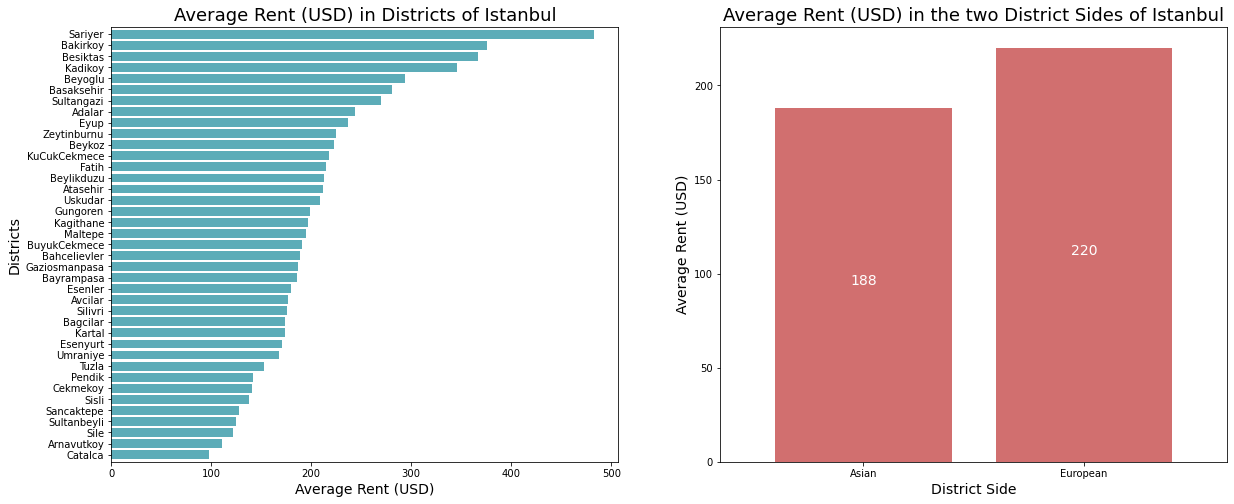

In [9]:
#Plotting the bar charts
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2) 

istanbul_main_sorted['Avg-Rent (USD)'].plot(kind='barh', figsize=(20, 8), width = 0.8, color = ['#5cacb8'], ax=ax0)
ax0.set_xlabel('Average Rent (USD)', size = 14) 
ax0.set_ylabel('Districts', size = 14) 
ax0.set_title('Average Rent (USD) in Districts of Istanbul', size = 18)
    
istanbul_main_side['Avg-Rent (USD)'].plot(kind='bar', figsize=(20, 8), width = 0.8, color = ['#d16f6f'], ax=ax1)
ax1.set_xlabel('District Side', size = 14) 
ax1.set_ylabel('Average Rent (USD)', size = 14) 
ax1.set_title('Average Rent (USD) in the two District Sides of Istanbul', size = 18)
ax1.set_xticklabels(istanbul_main['District Side'], rotation=0)

for p in ax1.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax1.annotate(f'{int(height)}', (x + width/2, y + height*0.5), color='white', ha='center', size = 14)

plt.show()

As we can see from the previous charts that **Sariyer** has the highest average rental houshing price equals to 483 USD, and **Catalca** has the lowest average rental houshing price equals to 98 USD.

Also we can see that there is no significant difference between the average rental housing price in the Asian side and the European side. But in general we can say that the European side is more expensive than the Asian side.

After that I visualized the frequency of rental housing prices in different ranges using `histogram`. Thus I could create labels which involve pricing features as follows:

In [10]:
istanbul_rental = istanbul_rental.sort_values('Avg-Rent (USD)').reset_index(drop=True)
istanbul_rental = istanbul_rental.drop(['District Side', 'Avg-Rent (Lira)'], axis=1)
istanbul_rental.head()

,District,Avg-Rent (USD)
0,Catalca,98
1,Arnavutkoy,111
2,Sile,122
3,Sultanbeyli,125
4,Sancaktepe,128


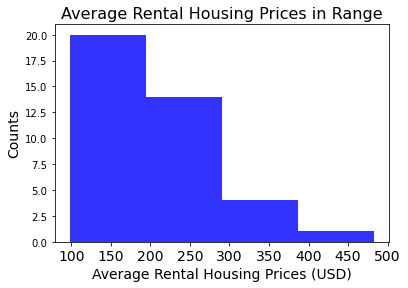

In [11]:
num_bins = 4
n, bins, patches = plt.hist(istanbul_rental['Avg-Rent (USD)'], num_bins, facecolor='blue', alpha=0.8)
plt.title("Average Rental Housing Prices in Range",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Average Rental Housing Prices (USD)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

As it seems in above histogram, we can define the ranges as below:

 - 100-200 ARHP: "Low Level RHP"
 - 200-300 ARHP: "Mid-1 Level RHP"
 - 300-400 ARHP: "Mid-2 Level RHP"
 - '>' 400 ARHP: "High Level RHP"

Then I created a new column "Rental_labels" with those levels.

In [12]:
level = []
for i in range(0,len(istanbul_rental)):
    if (istanbul_rental['Avg-Rent (USD)'][i] < 200):
        level.append("Low Level RHP")
    elif (istanbul_rental['Avg-Rent (USD)'][i] >= 200 and istanbul_rental['Avg-Rent (USD)'][i] < 300):
        level.append("Mid-1 Level RHP")
    elif (istanbul_rental['Avg-Rent (USD)'][i] >= 300 and istanbul_rental['Avg-Rent (USD)'][i] < 400):
        level.append("Mid-2 Level RHP")
    else:
        level.append("High Level RHP")   

istanbul_rental['Rental_labels'] = level
istanbul_rental.head()

,District,Avg-Rent (USD),Rental_labels
0,Catalca,98,Low Level RHP
1,Arnavutkoy,111,Low Level RHP
2,Sile,122,Low Level RHP
3,Sultanbeyli,125,Low Level RHP
4,Sancaktepe,128,Low Level RHP


_The prevoious table will be used later in the analysis._

Finally, using the JSON file from *Sercan Yıldız* github repository, I visualized the districts based on the average rental price in US dollars, but this time using a choropleth map:

In [13]:
!wget --quiet https://raw.githubusercontent.com/Srcanyildiz/istanbul/master/istanbul_geo_1.json -O istanbul_geo.json 
istanbul_geo = r'istanbul_geo.json'

In [14]:
istanbul_map = folium.Map(location=[latitude, longitude], zoom_start=10)

istanbul_map.choropleth(
    geo_data=istanbul_geo,
    data=istanbul_main,
    columns=['District','Avg-Rent (USD)'],
    key_on='feature.properties.name_2',
    fill_color='YlOrBr', 
    fill_opacity=0.5, 
    line_opacity=0.2,
    legend_name='Average Rental Housing Prices in Istanbul',
    highlight=True
)

for lat, lon, district, pop in zip(istanbul_main['Latitude'], istanbul_main['Longitude'], istanbul_main['District'], istanbul_main['Population (2019)']):
    label = folium.Popup(str(district) + ", " + str(pop), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color= 'black',
        fill=True,
        fill_color= 'black',
        fill_opacity=0.5).add_to(istanbul_map)
    
    
istanbul_map

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


#### 2.6.2 Exploring the Districts

Next, I started utilizing the `Foursquare API` to explore the districts and segment them.

##### 2.6.2.1 Define Foursquare Credentials and Version

In [15]:
CLIENT_ID = '<hidden>' # My Foursquare ID
CLIENT_SECRET = '<hidden>' # My Foursquare Secret
VERSION = '20200605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

My credentails:
CLIENT_ID: <hidden>
CLIENT_SECRET: <hidden>


##### 2.6.2.2 Explore the first district in our main dataframe

I got the district's name and its latitude and longitude values.

In [17]:
district_name = istanbul_main.loc[0, 'District']
district_latitude = istanbul_main.loc[0, 'Latitude']
district_longitude = istanbul_main.loc[0, 'Longitude'] 

print('Latitude and longitude values of {} are {}, {}.'.format(district_name, 
                                                               district_latitude, 
                                                               district_longitude))

Latitude and longitude values of Adalar are 40.87625945, 29.091027262109563.


##### 2.6.2.3 Get the top 100 venues that are in Adalar

I set the limit equals 100 and the radius equals 500.

Then I created the GET request and send it.

In [18]:
LIMIT = 100
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, district_latitude, district_longitude, VERSION, radius, LIMIT)

results = requests.get(url).json()

Before I proceeded, I used the `get_category_type` function that extracts the category of the venue.

In [19]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Then I was ready to clean the json and structure it into a pandas dataframe.

In [20]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Merit Halki Palace Hotel,Hotel,40.878802,29.090974
1,İnönü Evi Müzesi,History Museum,40.878251,29.093647
2,L'isola Guesthouse,Bed & Breakfast,40.877038,29.096136
3,Huseyin Rahmi Gurpinar Muzesi,Museum,40.877224,29.092228
4,Aqua Green Beach,Beach,40.880498,29.090354


Then I saw how many venues were returned by Foursquare.

In [21]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

20 venues were returned by Foursquare.


##### 2.6.2.4 Explore all the districts in our master dataframe

I used a function to repeat the same process to all the districts in our main dataframe.

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

After that I run the above function on each district and created a new dataframe called *istanbul_venues*.

In [23]:
istanbul_venues = getNearbyVenues(names=istanbul_main['District'],
                                   latitudes=istanbul_main['Latitude'],
                                   longitudes=istanbul_main['Longitude'])

Adalar
Arnavutkoy
Atasehir
Avcilar
Bagcilar
Bahcelievler
Bakirkoy
Basaksehir
Bayrampasa
Besiktas
Beykoz
Beylikduzu
Beyoglu
BuyukCekmece
Catalca
Cekmekoy
Esenler
Esenyurt
Eyup
Fatih
Gaziosmanpasa
Gungoren
Kadikoy
Kagithane
Kartal
KuCukCekmece
Maltepe
Pendik
Sancaktepe
Sariyer
Silivri
Sultanbeyli
Sultangazi
Sile
Sisli
Tuzla
Umraniye
Uskudar
Zeytinburnu


I checked the size of the resulting dataframe.

In [24]:
print(istanbul_venues.shape)
istanbul_venues.head()

(3837, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adalar,40.876259,29.091027,İnönü Evi Müzesi,40.878251,29.093647,History Museum
1,Adalar,40.876259,29.091027,Merit Halki Palace Hotel,40.878802,29.090974,Hotel
2,Adalar,40.876259,29.091027,L'isola Guesthouse,40.877038,29.096136,Bed & Breakfast
3,Adalar,40.876259,29.091027,Heybeliada Su Sporları Kulübü,40.882365,29.089167,Pool
4,Adalar,40.876259,29.091027,Luz Café,40.877528,29.097877,Café


Then I checked how many venues were returned for each district.

In [25]:
venues_data = istanbul_venues.groupby('District').count().reset_index()
venues_data.rename(columns={'Venue': 'Count'}, inplace=True)
venues_data = venues_data.drop(['District Latitude', 'District Longitude', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1)
venues_data = venues_data.sort_values('Count', ascending=False).reset_index(drop=True)
venues_data.head()

,District,Count
0,Adalar,100
1,Sariyer,100
2,Kadikoy,100
3,Kagithane,100
4,Kartal,100


##### 2.6.2.5 Visualize the previous results

I created a `bar chart` illustrates the total number of venues in each district as follows:

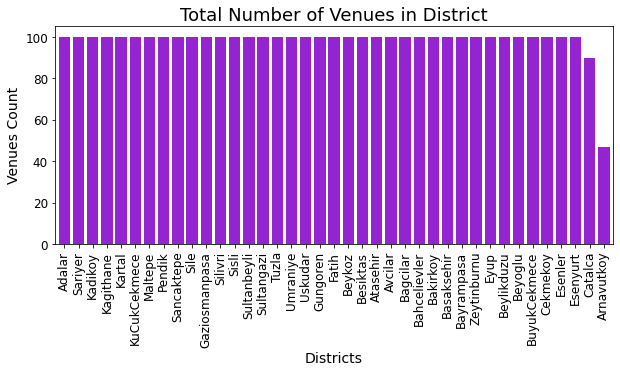

In [26]:
venues_data.set_index('District', inplace=True) #Setting the district name as index

#Plooting the bar chart
venues_data['Count'].plot(kind='bar', figsize=(10, 4), width = 0.8, color = ['#9424d1'])
plt.xlabel('Districts', size = 14) 
plt.ylabel('Venues Count', size = 14) 
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title('Total Number of Venues in District', size = 18) 

plt.show()

Here is we can see that all districts except *Catalca* and *Arnavutkoy* reached the 100 limit of venues.

The result doesn't mean that inquiry run all the possible results in districts. Actually, it depends on given Latitude and Longitude information and here is we just run single Latitude and Longitude pair for each district. We can increase the possibilities of venues information in each district with more Latitude and Longitude information.

I checked how many unique categories can be curated from all the returned venues.

In [27]:
print('There are {} uniques categories.'.format(len(istanbul_venues['Venue Category'].unique())))

There are 304 uniques categories.


##### 2.6.2.6 Analyze each district

I analyzed each district based on venues information.

In [28]:
# one hot encoding
istanbul_onehot = pd.get_dummies(istanbul_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
istanbul_onehot['District'] = istanbul_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [istanbul_onehot.columns[-1]] + list(istanbul_onehot.columns[:-1])
istanbul_onehot = istanbul_onehot[fixed_columns]

istanbul_onehot.head()

,District,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,...,Watch Shop,Water Park,Waterfront,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place
0,Adalar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adalar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adalar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adalar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adalar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Then I grouped rows by district and by taking the mean of the frequency of occurrence of each category.

In [29]:
istanbul_grouped = istanbul_onehot.groupby('District').mean().reset_index()
istanbul_grouped.head()

,District,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,...,Watch Shop,Water Park,Waterfront,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place
0,Adalar,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.01,0.00,0.0,0.0,0.00,0.0,0.0,0.00
1,Arnavutkoy,0.0,0.0,0.0,0.0,0.0,0.042553,0.0,0.021277,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00
2,Atasehir,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.010000,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.01
3,Avcilar,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.010000,0.0,...,0.0,0.0,0.00,0.01,0.0,0.0,0.02,0.0,0.0,0.00
4,Bagcilar,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.000000,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.01,0.0,0.0,0.00


I put the previous result into a pandas dataframe.

But first, I used a function to sort the venues in descending order.

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Second, I created a new dataframe and displayed the top 10 venues for each district.

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
districts_venues_sorted = pd.DataFrame(columns=columns)
districts_venues_sorted['District'] = istanbul_grouped['District']

for ind in np.arange(istanbul_grouped.shape[0]):
    districts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(istanbul_grouped.iloc[ind, :], num_top_venues)

districts_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adalar,Seafood Restaurant,Café,Beach,Restaurant,Fast Food Restaurant,Ice Cream Shop,Turkish Restaurant,Trail,Campground,Bar
1,Arnavutkoy,Café,Restaurant,Turkish Restaurant,Kofte Place,Dessert Shop,Arcade,Fish & Chips Shop,Gym,Steakhouse,Breakfast Spot
2,Atasehir,Restaurant,Coffee Shop,Seafood Restaurant,Steakhouse,Kebab Restaurant,Hotel,Gym / Fitness Center,Park,Café,Shopping Mall
3,Avcilar,Café,Dessert Shop,Coffee Shop,Restaurant,Bar,Burger Joint,Gym / Fitness Center,Pizza Place,Pub,Mobile Phone Shop
4,Bagcilar,Café,Dessert Shop,Steakhouse,Gym,Turkish Restaurant,Kebab Restaurant,Coffee Shop,Hookah Bar,Gym / Fitness Center,Pizza Place


#### 2.6.3 Clustering the Districts

I Run `k-means` to cluster the districts into 3 clusters.

In [32]:
kclusters = 3

istanbul_grouped_clusters = istanbul_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(istanbul_grouped_clusters)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       2, 1, 1, 2, 1, 2, 1, 0, 0, 1, 1, 1, 2, 0, 1, 1, 1], dtype=int32)

Then I created a new dataframe that includes the cluster as well as the top 10 venues for each district.

In [33]:
istanbul_merged = istanbul_main

# add clustering labels
districts_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge istanbul_grouped with istanbul_main to add latitude/longitude for each district
istanbul_merged = istanbul_merged.join(districts_venues_sorted.set_index('District'), on='District')

istanbul_merged.head()

,District,District Side,Avg-Rent (Lira),Avg-Rent (USD),Population (2019),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adalar,Asian,1874,244,15238,40.876259,29.091027,0,Seafood Restaurant,Café,Beach,Restaurant,Fast Food Restaurant,Ice Cream Shop,Turkish Restaurant,Trail,Campground,Bar
1,Arnavutkoy,European,857,111,282488,41.184182,28.740729,2,Café,Restaurant,Turkish Restaurant,Kofte Place,Dessert Shop,Arcade,Fish & Chips Shop,Gym,Steakhouse,Breakfast Spot
2,Atasehir,Asian,1632,212,425094,40.984749,29.106720,1,Restaurant,Coffee Shop,Seafood Restaurant,Steakhouse,Kebab Restaurant,Hotel,Gym / Fitness Center,Park,Café,Shopping Mall
3,Avcilar,European,1364,177,448882,40.980135,28.717547,2,Café,Dessert Shop,Coffee Shop,Restaurant,Bar,Burger Joint,Gym / Fitness Center,Pizza Place,Pub,Mobile Phone Shop
4,Bagcilar,European,1337,174,745125,41.033899,28.857898,1,Café,Dessert Shop,Steakhouse,Gym,Turkish Restaurant,Kebab Restaurant,Coffee Shop,Hookah Bar,Gym / Fitness Center,Pizza Place


After that I was able to estimate the number of **1st Most Common Venues** in each cluster. Thus, I could create a `bar chart` which may help me to find proper label names for each cluster.

In [34]:
count_venue = istanbul_merged
count_venue = count_venue.drop(['District','District Side', 'Avg-Rent (Lira)', 'Avg-Rent (USD)', 'Population (2019)', 'Latitude', 'Longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#I transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,Beach,Café,Coffee Shop,Gym,Lounge,Restaurant,Seafood Restaurant
0,1,2,0,0,0,0,1
1,0,22,1,1,1,1,0
2,0,9,0,0,0,0,0


Text(0, 0.5, 'Venues Count')

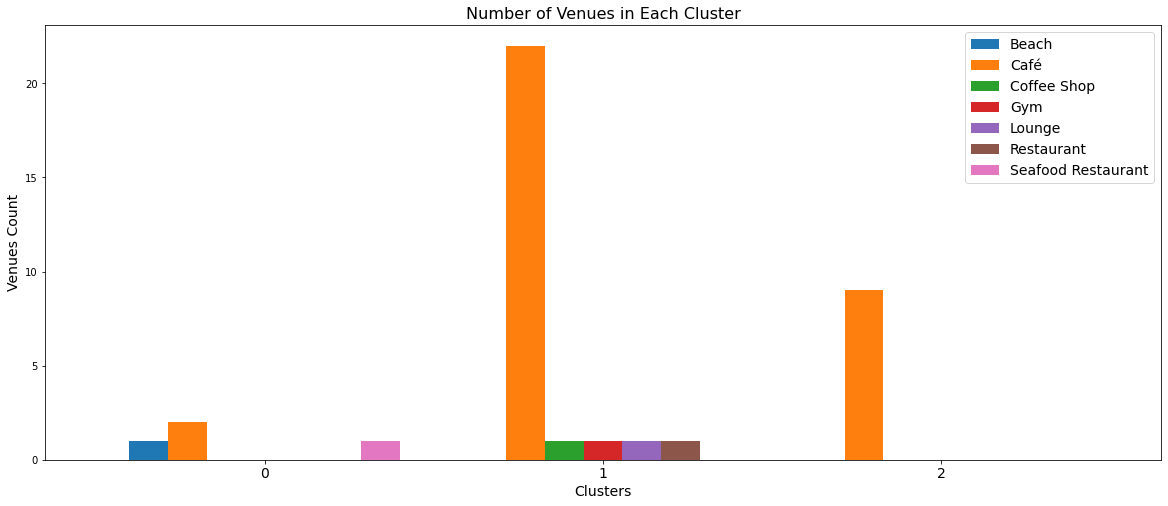

In [35]:
#creating a bar chart of "Number of Venues in Each Cluster"
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Clusters', fontsize=14)
plt.ylabel('Venues Count', fontsize=14)

When we examine above graph we can label each cluster as follows:

 - Cluster 0 : "Coastal Venues"
 - Cluster 1 : "Multiple Social Venues"
 - Cluster 2 : "Cafe Venues"

I assigned those new labels to existing label of clusters:

In [36]:
cluster_labels = {'Clusters': [0,1,2], 'Labels': ["Coastal Venues", "Multiple Social Venues", "Cafe Venues"]}
cluster_labels = pd.DataFrame(data=cluster_labels)
cluster_labels

,Clusters,Labels
0,0,Coastal Venues
1,1,Multiple Social Venues
2,2,Cafe Venues


One of the aims of this project was also to show the number of top 3 venues information for each district on the map. Thus, I grouped each district by the number of top 3 venues and I combined those information in Join column.

In [37]:
top3 = istanbul_venues.groupby(['District','Venue Category']).size().reset_index(name='Counts')
top3 = top3.sort_values(['District','Counts'], ascending=False).groupby('District').head(3).reset_index(drop=True)

top3['Venues'] = top3['Counts'].map(str) + " " + top3['Venue Category']
top3 = top3.groupby(['District'])['Venues'].apply(", ".join).reset_index()

top3.head()

,District,Venues
0,Adalar,"19 Seafood Restaurant, 15 Café, 13 Beach"
1,Arnavutkoy,"11 Café, 4 Restaurant, 4 Turkish Restaurant"
2,Atasehir,"10 Restaurant, 6 Coffee Shop, 5 Seafood Restau..."
3,Avcilar,"30 Café, 6 Dessert Shop, 5 Coffee Shop"
4,Bagcilar,"18 Café, 7 Dessert Shop, 6 Gym"


## 3. Results

### 3.1 The Master dataframe with Results

I merged the new variables with related cluster information in our main *istanbul_merged* table.

In [38]:
import numpy as np

result = pd.merge(istanbul_merged, 
                    top3[['District', 'Venues']],
                    left_on = 'District',
                    right_on = 'District',
                    how = 'left')
result= pd.merge(result, 
                    cluster_labels[['Clusters', 'Labels']],
                    left_on = 'Cluster Labels',
                    right_on = 'Clusters',
                    how = 'left')
result = pd.merge(result, 
                    istanbul_rental[['District', 'Rental_labels']],
                    left_on = 'District',
                    right_on = 'District',
                    how = 'left')

result = result.drop(['Clusters'], axis=1)
result.head()

,District,District Side,Avg-Rent (Lira),Avg-Rent (USD),Population (2019),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,...,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Venues,Labels,Rental_labels
0,Adalar,Asian,1874,244,15238,40.876259,29.091027,0,Seafood Restaurant,Café,...,Restaurant,Fast Food Restaurant,Ice Cream Shop,Turkish Restaurant,Trail,Campground,Bar,"19 Seafood Restaurant, 15 Café, 13 Beach",Coastal Venues,Mid-1 Level RHP
1,Arnavutkoy,European,857,111,282488,41.184182,28.740729,2,Café,Restaurant,...,Kofte Place,Dessert Shop,Arcade,Fish & Chips Shop,Gym,Steakhouse,Breakfast Spot,"11 Café, 4 Restaurant, 4 Turkish Restaurant",Cafe Venues,Low Level RHP
2,Atasehir,Asian,1632,212,425094,40.984749,29.106720,1,Restaurant,Coffee Shop,...,Steakhouse,Kebab Restaurant,Hotel,Gym / Fitness Center,Park,Café,Shopping Mall,"10 Restaurant, 6 Coffee Shop, 5 Seafood Restau...",Multiple Social Venues,Mid-1 Level RHP
3,Avcilar,European,1364,177,448882,40.980135,28.717547,2,Café,Dessert Shop,...,Restaurant,Bar,Burger Joint,Gym / Fitness Center,Pizza Place,Pub,Mobile Phone Shop,"30 Café, 6 Dessert Shop, 5 Coffee Shop",Cafe Venues,Low Level RHP
4,Bagcilar,European,1337,174,745125,41.033899,28.857898,1,Café,Dessert Shop,...,Gym,Turkish Restaurant,Kebab Restaurant,Coffee Shop,Hookah Bar,Gym / Fitness Center,Pizza Place,"18 Café, 7 Dessert Shop, 6 Gym",Multiple Social Venues,Low Level RHP


### 3.2 Map the Cluster Results

Finally, I visualized the resulting clusters.

In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, pop, cluster, venues, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['District'], result['Population (2019)'], result['Labels'], result['Venues'], result['Cluster Labels'], result['Rental_labels']):
    label = folium.Popup(str(poi) + ", " + str(pop) + " / " + str(label) + " - " + str(cluster) + " / " + str(venues), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color= rainbow[cluster_number-1],
        popup=label,
        fill_color = rainbow[cluster_number-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

### 3.3 Map the Rental Housing Prices with Cluster Results

In final section, I created a `choropleth map` which has the below information for each district:

- District name
- Populiaton
- Cluster name,
- Rental Housing Price (RHP) level
- Top 3 most common venues

In [40]:
istanbul_map_final = folium.Map(location=[latitude, longitude], zoom_start=10)

istanbul_map_final.choropleth(
    geo_data=istanbul_geo,
    data=istanbul_main,
    columns=['District','Avg-Rent (USD)'],
    key_on='feature.properties.name_2',
    fill_color='YlOrRd', 
    fill_opacity=0.5, 
    line_opacity=0.2,
    legend_name='Average Rental Housing Prices in Istanbul',
    highlight=True
)

markers_colors = []
for lat, lon, poi, pop, cluster, venues, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['District'], result['Population (2019)'], result['Labels'], result['Venues'], result['Cluster Labels'], result['Rental_labels']):
    label = folium.Popup(str(poi) + ", " + str(pop) + " / " + str(label) + " - " + str(cluster) + " / " + str(venues), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= rainbow[cluster_number-1],
        fill=True,
        fill_color= rainbow[cluster_number-1],
        fill_opacity=1).add_to(istanbul_map_final)
   
#display map
istanbul_map_final

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## 3. Discussion

As I mentioned before, Istanbul is a big city with a high population density in a narrow area. The total number of measurements and population densities of the 39 districts in total can vary. As there is such a complexity, very different approaches can be tried in clustering and classification studies. Moreover, it is obvious that not every classification method can yield the same high quality results for this metropol.

I used the `K-means` algorithm as part of this clustering study. When I tested the Elbow method, I set the optimum _k_ value to 3. However, only 39 district coordinates were used. For more detailed and accurate guidance, the data set can be expanded and the details of the neighborhood or street can also be drilled.

I also performed data analysis through this information by using the coordinates of districts from a wikipedia page and rental home price averages from a housing retail web page.

I ended the study by visualizing the data and clustering information on the Istanbul map.

## 4. Conclusion

As a result, students are turning to new cities to start or continue their studies. For this reason, students can achieve better outcomes through their access to the platforms where such information is provided.

Not only for students but also city managers can manage the city more regularly by using similar data analysis types or platforms.

## 5. References

[1] [List of Districts of Istanbul](https://en.wikipedia.org/wiki/List_of_districts_of_Istanbul)

[2] [Rental Housing Prices of Istanbul](https://www.endeksa.com)

[3] [Foursquare API](https://foursquare.com)

[4] [Second-level Administrative Divisions of the Turkey](https://geo.nyu.edu/catalog/stanford-nj696zj1674)

